# Nanograd automatic differention framework

In [69]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from typing import Union
from math import tanh


class Var:
    """
    A variable which holds a number and enables gradient computations.
    """

    def __init__(self, val: Union[float, int], parents=None):
        assert type(val) in {float, int}
        if parents is None:
            parents = []
        self.v = val
        self.parents = parents
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for parent, grad in self.parents:
            parent.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, [(self, other.v), (other, self.v)])

    def __pow__(self, power: Union[float, int]) -> 'Var':
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def tanh(self) -> 'Var':
        return Var(tanh(self.v), [(self, 1 - tanh(self.v) ** 2)])

    def relu(self) -> 'Var':
        return Var(self.v if self.v > 0.0 else 0.0, [(self, 1.0 if self.v > 0.0 else 0.0)])

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

# Create an artificial 3D dataset

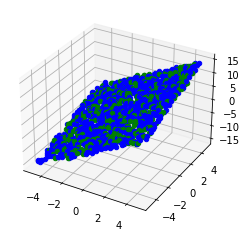

In [70]:
from math import sin
import random
import tqdm as tqdm
import matplotlib.pyplot as plt

def sample_data(noise=0.4):
    x = (random.random() - 0.5) * 10
    y = (random.random() - 0.5) * 10
    return x, y, 2.0 * x + y + random.gauss(0, noise)

train_data = [sample_data() for _ in range(1000)]
val_data = [sample_data() for _ in range(500)]

ax = plt.axes(projection='3d')
for x, y, z in train_data:  
  ax.scatter3D(x,y,z, c='b')
for x, y, z in val_data:
  ax.scatter3D(x,y,z, c='g')

# Building the neural network.


In [71]:
from typing import Sequence

class Initializer:

  def init_weights(self, n_in, n_out) -> Sequence[Sequence[Var]]:    
    raise NotImplementedError

  def init_bias(self, n_out) -> Sequence[Var]:
    raise NotImplementedError


class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

In [72]:
class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer: Initializer = NormalInitializer()):
        """
          n_in: the number of inputs to the layer
          n_out: the number of output neurons in the layer
          act_fn: the non-linear activation function for each neuron
          initializer: The initializer to use to initialize the weights and biases
        """
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      """Returns all the vars of the layer (weights + biases) as a single flat list"""
      params_list = [weight for out_list in self.weights for weight in out_list]
      #for i in len(self.weights):
      #  for j in len(self.weights[0]):
      #    params_list.append(self.weights[i][j])
      params_list += self.bias
      return params_list
      
      
    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        """ 
        inputs: A n_in length vector of Var's corresponding to the previous layer outputs or the data if it's the first layer.

        Computes the forward pass of the dense layer: For each output neuron, j, it computes: act_fn(weights[i][j]*inputs[i] + bias[j])
        Returns a vector of Vars that is n_out long.
        """
        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"

        output_activations = []
        for j in range(len(self.bias)):
          sum_of_weights = self.bias[j]
          for i in range(len(self.weights)):
            sum_of_weights += self.weights[i][j] * inputs[i]
          output_activations.append(self.act_fn(sum_of_weights))
        
        return output_activations

In [73]:
class MLP:
  def __init__(self, layers: Sequence[DenseLayer]):
    self.layers = layers

  def parameters(self) -> Sequence[Var]:
    """ Returns all the parameters of the layers as a flat list"""
    all_params_list = []
    for l in self.layers:
      all_params_list += l.parameters()
    return all_params_list

  def forward(self, x: Sequence[Var]) -> Sequence[Var]:
    """
    Computes the forward pass of the MLP: x = layer(x) for each layer in layers
    """
    for l in self.layers:
      x = l.forward(x)
    return x


In [74]:
class SGD:
  def __init__(self, parameters: Sequence[Var], learning_rate: float):
    self.parameters = parameters
    self.learning_rate = learning_rate

  def zero_grad(self):
    """ Set the gradient to zero for all parameters """
    for p in self.parameters:
      p.grad = 0.0

  def step(self):
    """Performs a single step of SGD for each parameter: p = p - learning_rate * grad_p """
    for p in self.parameters:
      p.v = p.v - self.learning_rate * p.grad

In [75]:
def squared_loss(t: Var, y: Var) -> Var:  
  return (t-y)**2

Initialize the Multi Layer Perceptron with random weights

In [80]:
mlp = MLP([
    DenseLayer(2, 16, lambda x: x.tanh()), # take 1 initial input to a hidden layer of 16 neurons. Activation function used in this step is a tangent of x
    DenseLayer(16, 1, lambda x: x) # from the 16 neurons hidden layer give 1 output. Actiovation functions used in this step is a linear function
]) 

Plot the data as outputted by the network before training

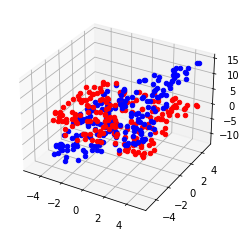

In [77]:
ax = plt.axes(projection='3d')

for _ in range(200):
  x, y, z_target = sample_data()
  z = mlp.forward([Var(x), Var(y)])
  ax.scatter3D(x,y,z_target, c='b')
  ax.scatter3D(x,y,z[0].v, c='r')

Train the neural network for 100 gradient updates. Each gradient will be calculated on the average loss over a minibatch of samples. The plot shows the loss for each batch.

100%|██████████| 70/70 [00:03<00:00, 20.85it/s]


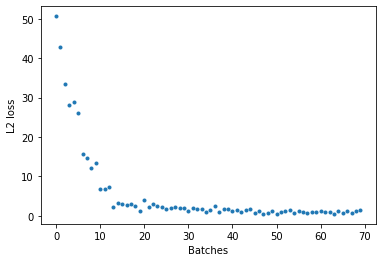

In [81]:
learning_rate = 0.01 
optim = SGD(mlp.parameters(), learning_rate) # Initialize the stochastic gradient descent with the parameters from the nn

batch_size = 64
losses = []

for i in tqdm.tqdm(range(70)):
    loss = Var(0.0)
    for _ in range(batch_size): # Runs a batch of iterations, accumulating the losses compared to the training data sampled
        x, y, z_target = random.choice(train_data) # Take a random sample from the training data
        x = Var(x)
        y = Var(y)
        z_target = Var(z_target)
        z = mlp.forward([x,y])
        loss += squared_loss(z_target, z[0])

    loss = loss / Var(batch_size) # Average the losses by the batch that was just run
    losses.append(loss.v)
    optim.zero_grad() # Current batch training finished: reset the gradient from the previous batch of training
    loss.backward() # Calculate the gradient of each parameter based on the batch loss function result
    optim.step()# Adjust each parameter based on the calculated gradients and the learning rate

plt.plot(losses, '.')
plt.ylabel('L2 loss')
plt.xlabel('Batches')
plt.show()

Let's plot the data again now that the neural network has been trained

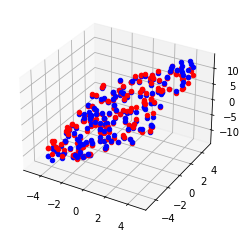

In [82]:
ax = plt.axes(projection='3d')

for _ in range(200):
  x, y, z_target = random.choice(val_data)
  z = mlp.forward([Var(x), Var(y)])
  ax.scatter3D(x,y,z_target, c='b')
  ax.scatter3D(x,y,z[0].v, c='r')